<table class="table table-bordered">
    <tr>
        <th style="width:250px"><img src="https://www.np.edu.sg/images/default-source/default-album/img-logo.png?sfvrsn=764583a6_0" style="width: 100%; height: 125px; "></th>
        <th style="text-align:center;"><h1>Distributed Data Pipelines</h1><h2>Assignment 1 </h2><h3>Diploma in Data Science</h3></th>
    </tr>
</table>

Learning Objectives:
- Design PySpark Based Machine Learning
- Execute PySpark Syntax Correctly
- Evaluate and Select Final Model based on Metrics

You will be **graded on the use of PySpark**, so usage of **Pandas itself should be avoided as much as possible**, especially if a particular native method or function is already available in PySpark. **Penalties will be imposed in such cases.**

<a id="top"></a>
[Back to bottom (report)](#bottom)

In [1]:
# import the packages
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName("Assignment 1").getOrCreate()
import pyspark.sql.functions as F
from pyspark.sql.functions import round, col, avg, asc, desc

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler

### Step 1: Problem Statement Formulation

In [2]:
# load and explore data
hdbResale =spark.read.csv("./data/sg_flat_prices_mod.csv", header=True, inferSchema=True) # inferSchema auto detects data type

In [3]:
# value based problem statement
# predict the resale prices of any HDB resale transaction excluding $1million 

In [4]:
# View the first 5 rows of df
hdbResale.show(5)

+----+-----+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+---------------+------------+
|year|month|      town|flat_type|block|      street_name|storey_range|floor_area_sqm|    flat_model|lease_commence_date|remaining_lease|resale_price|
+----+-----+----------+---------+-----+-----------------+------------+--------------+--------------+-------------------+---------------+------------+
|2017|    1|ANG MO KIO|   2 ROOM|  406|ANG MO KIO AVE 10|    10 TO 12|          44.0|      Improved|               1979|            736|    232000.0|
|2017|    1|ANG MO KIO|   3 ROOM|  108| ANG MO KIO AVE 4|    01 TO 03|          67.0|New Generation|               1978|            727|    250000.0|
|2017|    1|ANG MO KIO|   3 ROOM|  602| ANG MO KIO AVE 5|    01 TO 03|          67.0|New Generation|               1980|            749|    262000.0|
|2017|    1|ANG MO KIO|   3 ROOM|  465|ANG MO KIO AVE 10|    04 TO 06|          68.0|New Generation|

In [5]:
# display info of df
hdbResale.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- town: string (nullable = true)
 |-- flat_type: string (nullable = true)
 |-- block: string (nullable = true)
 |-- street_name: string (nullable = true)
 |-- storey_range: string (nullable = true)
 |-- floor_area_sqm: double (nullable = true)
 |-- flat_model: string (nullable = true)
 |-- lease_commence_date: integer (nullable = true)
 |-- remaining_lease: integer (nullable = true)
 |-- resale_price: double (nullable = true)



In [6]:
hdbResale.groupBy('flat_type').count().orderBy(asc('flat_type')).show()

+----------------+-----+
|       flat_type|count|
+----------------+-----+
|          1 ROOM|   29|
|          2 ROOM|  919|
|          3 ROOM|15589|
|          4 ROOM|26592|
|          5 ROOM|15916|
|       EXECUTIVE| 5169|
|MULTI-GENERATION|   33|
+----------------+-----+



In [7]:
hdbResale.groupBy('town').count().orderBy(desc('count')).show()

+---------------+-----+
|           town|count|
+---------------+-----+
|      WOODLANDS| 4988|
|       SENGKANG| 4970|
|    JURONG WEST| 4945|
|         YISHUN| 4333|
|       TAMPINES| 4080|
|        PUNGGOL| 4013|
|          BEDOK| 3429|
|        HOUGANG| 2982|
|     ANG MO KIO| 2917|
|  CHOA CHU KANG| 2660|
|    BUKIT MERAH| 2578|
|    BUKIT BATOK| 2451|
|  BUKIT PANJANG| 2384|
|      TOA PAYOH| 2184|
|KALLANG/WHAMPOA| 1916|
|      PASIR RIS| 1836|
|      SEMBAWANG| 1754|
|     QUEENSTOWN| 1708|
|        GEYLANG| 1554|
|    JURONG EAST| 1446|
+---------------+-----+
only showing top 20 rows



### Step 2: Exploratory Data Analysis and Data Cleansing

In [8]:
# show null count 
# "floor_area_sqm" contains null values
from pyspark.sql.functions import col, isnan, when, count
hdbResale.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in hdbResale.columns]).show()

+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+
|year|month|town|flat_type|block|street_name|storey_range|floor_area_sqm|flat_model|lease_commence_date|remaining_lease|resale_price|
+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+
|   0|    0|   0|        0|    0|          0|           0|            50|         0|                  0|              0|           0|
+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+



In [9]:
# average resale_price by "flat_type"
hdbResale.groupBy('flat_type').avg('resale_price').orderBy(asc('flat_type')).show()

+----------------+------------------+
|       flat_type| avg(resale_price)|
+----------------+------------------+
|          1 ROOM| 186181.6551724138|
|          2 ROOM|233600.68988030468|
|          3 ROOM| 307712.2837821541|
|          4 ROOM| 432760.1087740674|
|          5 ROOM| 528812.8562151295|
|       EXECUTIVE| 625390.6592435675|
|MULTI-GENERATION| 806804.6060606061|
+----------------+------------------+



In [10]:
# average resale_price by "month"
hdbResale.groupBy('month').avg('resale_price').orderBy(asc('month')).show()

+-----+------------------+
|month| avg(resale_price)|
+-----+------------------+
|    1|  433466.917148869|
|    2|439305.31306053814|
|    3| 445615.8173404451|
|    4|439311.25100858364|
|    5|441666.82297063904|
|    6| 440919.6439529076|
|    7|  439641.701831183|
|    8| 439921.1433226514|
|    9| 439111.6647188353|
|   10|434383.18886846065|
|   11|435931.37539263384|
|   12|436425.81054365734|
+-----+------------------+



In [11]:
# average resale_price by "remaining_lease"
hdbResale.groupBy('remaining_lease').avg('resale_price').orderBy(desc('avg(resale_price)')).show()

+---------------+-----------------+
|remaining_lease|avg(resale_price)|
+---------------+-----------------+
|           1156|957666.6666666666|
|           1158|         861000.0|
|           1157|         839000.0|
|           1155|         799000.0|
|           1154|         750808.0|
|           1160|         695000.0|
|           1089|691077.1707317074|
|           1091|677325.0212765958|
|           1090|658312.2162162162|
|           1047|652199.9696969697|
|           1087|644040.5609756098|
|           1097|641233.2363636363|
|           1102|640235.1232876712|
|           1103|        640018.92|
|           1100|636991.8421052631|
|           1092|633314.2857142857|
|           1112| 632951.743119266|
|           1085|631547.7027027027|
|           1084|631487.3181818182|
|           1083|627395.0222222222|
+---------------+-----------------+
only showing top 20 rows



In [12]:
# average resale_price by "storey_range"
hdbResale.groupBy('storey_range').avg('resale_price').orderBy(asc('storey_range')).show()

+------------+------------------+
|storey_range| avg(resale_price)|
+------------+------------------+
|    01 TO 03| 394274.2836198463|
|    04 TO 06| 412115.9694568433|
|    07 TO 09|423477.66865580005|
|    10 TO 12|438086.75250713184|
|    13 TO 15|472987.87508488825|
|    16 TO 18|514570.93940520444|
|    19 TO 21| 591394.6781223805|
|    22 TO 24| 610122.5498092031|
|    25 TO 27| 666919.1401295896|
|    28 TO 30| 751391.7605177993|
|    31 TO 33| 800630.9291338583|
|    34 TO 36| 802757.8962962963|
|    37 TO 39| 845602.7674418605|
|    40 TO 42|       894045.9375|
|    43 TO 45|1037833.3333333334|
|    46 TO 48|1018845.4545454546|
|    49 TO 51|1022814.6666666666|
+------------+------------------+



In [13]:
# round resale price whole number
hdbResale = hdbResale.select("*",round("resale_price").alias("newResalePrice"))

In [14]:
# check for outliers
cols = ['newResalePrice']
bounds = {}
for col in cols:
    quantiles = hdbResale.approxQuantile(col, [0.25,0.75], 0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]

In [15]:
bounds

{'newResalePrice': [80500.0, 732500.0]}

In [16]:
outliers = hdbResale.select(*['newResalePrice'] + [
    (
        (hdbResale[c] < bounds[c][0]) |
        (hdbResale[c] > bounds[c][1])
    ).alias(c + '_0') for c in cols
])
outliers.show()

+--------------+----------------+
|newResalePrice|newResalePrice_0|
+--------------+----------------+
|      232000.0|           false|
|      250000.0|           false|
|      262000.0|           false|
|      265000.0|           false|
|      265000.0|           false|
|      275000.0|           false|
|      280000.0|           false|
|      285000.0|           false|
|      285000.0|           false|
|      285000.0|           false|
|      288500.0|           false|
|      295000.0|           false|
|      295000.0|           false|
|      297000.0|           false|
|      298000.0|           false|
|      298000.0|           false|
|      300000.0|           false|
|      301000.0|           false|
|      306000.0|           false|
|      312000.0|           false|
+--------------+----------------+
only showing top 20 rows



In [17]:
# count of total outliers
outliers.filter((outliers['newResalePrice_0']=="true")).count()

3827

In [18]:
# check outliers w resale price >= 1000000
outliers.filter((outliers['newResalePrice_0'] == "true") & (outliers['newResalePrice'] >= 1000000)).count()

181

In [19]:
# exclude resale price > 1mil
hdbResale = hdbResale.filter((hdbResale['newResalePrice'] < 1000000))

In [20]:
# # exclude resale price < 732500
# hdbResale = hdbResale.filter((hdbResale['newResalePrice'] < 732500))

In [21]:
# modify "remaining_lease" - "months" to "years"
hdbResale = hdbResale.withColumn("remaining_lease", F.col("remaining_lease")/12).select("*",
                                    round("remaining_lease").alias("newRemainingLease"))

In [22]:
# check which flat_type contains null values for floor_area_sqm
hdbResale.filter(hdbResale.floor_area_sqm.isNull()).select('flat_type', 'floor_area_sqm').show()

+---------+--------------+
|flat_type|floor_area_sqm|
+---------+--------------+
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
|   4 ROOM|          null|
+---------+--------------+
only showing top 20 rows



In [23]:
# to extract avg of 4 Room "floor_area_sqm" 
hdbResale.groupBy("flat_type").mean("floor_area_sqm").select("*",round("avg(floor_area_sqm)")
                                                             .alias("floor_area_sqm")).show()

+----------------+-------------------+--------------+
|       flat_type|avg(floor_area_sqm)|floor_area_sqm|
+----------------+-------------------+--------------+
|          3 ROOM|  68.26803746712004|          68.0|
|          1 ROOM|               31.0|          31.0|
|          4 ROOM|  95.56819364325304|          96.0|
|          2 ROOM| 45.869423286180634|          46.0|
|       EXECUTIVE| 144.24313801829862|         144.0|
|          5 ROOM| 118.21902710919686|         118.0|
|MULTI-GENERATION|  164.8181818181818|         165.0|
+----------------+-------------------+--------------+



In [24]:
# check initial count 
hdbResale.filter((hdbResale["floor_area_sqm"] == "96") &
                  (hdbResale["flat_type"] == "4 ROOM")).count()

453

In [25]:
# fill nans with nearest whole no. for 4 Room flats 
hdbResale_new = hdbResale.na.fill(96,["floor_area_sqm"]) #re-assigned to new df

In [26]:
# after imputation, count increases
hdbResale_new.filter((hdbResale_new["floor_area_sqm"] == "96") &
                  (hdbResale_new["flat_type"] == "4 ROOM")).count()

503

In [27]:
# check - no more null count
from pyspark.sql.functions import col, isnan, when, count
hdbResale_new.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in hdbResale_new.columns]).show()

+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+--------------+-----------------+
|year|month|town|flat_type|block|street_name|storey_range|floor_area_sqm|flat_model|lease_commence_date|remaining_lease|resale_price|newResalePrice|newRemainingLease|
+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+--------------+-----------------+
|   0|    0|   0|        0|    0|          0|           0|             0|         0|                  0|              0|           0|             0|                0|
+----+-----+----+---------+-----+-----------+------------+--------------+----------+-------------------+---------------+------------+--------------+-----------------+



In [28]:
# drop unnecessary columns
hdbResale_new = hdbResale_new.drop("block","street_name", "remaining_lease", "lease_commence_date", "resale_price")

In [29]:
# modify data types to "int"
hdbResale_new = hdbResale_new.withColumn("floor_area_sqm",col("floor_area_sqm").cast("int"))
hdbResale_new = hdbResale_new.withColumn("newResalePrice",col("newResalePrice").cast("int"))
hdbResale_new = hdbResale_new.withColumn("newRemainingLease",col("newRemainingLease").cast("int"))

# hdbResale_new = hdbResale_new.withColumn("pricePerRemainingLease", col("newResalePrice").cast("int")/col("newRemainingLease").cast("int"))

In [30]:
# create new feature "pricePerSqm"
hdbResale_new = hdbResale_new.withColumn("pricePerSqm",
                                         col("newResalePrice").cast("int")/col("floor_area_sqm").cast("int"))

In [31]:
# check correlation between newly created featuee VS its target
hdbResale_new.corr("pricePerSqm", "newResalePrice")

0.6780189161346482

In [32]:
# # exclude 1 room & multi-gen
# hdbResale_new = hdbResale_new.filter((hdbResale_new['flat_type'] != "1 ROOM") &
#                                      (hdbResale_new['flat_type'] != "MULTI-GENERATION"))

### Step 3: Data Wrangling and Transformation

In [33]:
# consider categorical and numerical variable treatment and transformations
strings_used = ["town", "flat_type", "storey_range", "flat_model"]

stage_string = [StringIndexer(inputCol= c, outputCol= c+"_string_encoded") for c in strings_used]
stage_one_hot = [OneHotEncoder(inputCol= c+"_string_encoded", outputCol= c+ "_one_hot") for c in strings_used]

ppl = Pipeline(stages= stage_string + stage_one_hot)
pyspark_index_ohe = ppl.fit(hdbResale_new).transform(hdbResale_new)
pyspark_index_ohe.show(5)

+----+-----+----------+---------+------------+--------------+--------------+--------------+-----------------+------------------+-------------------+------------------------+---------------------------+-------------------------+--------------+-----------------+--------------------+------------------+
|year|month|      town|flat_type|storey_range|floor_area_sqm|    flat_model|newResalePrice|newRemainingLease|       pricePerSqm|town_string_encoded|flat_type_string_encoded|storey_range_string_encoded|flat_model_string_encoded|  town_one_hot|flat_type_one_hot|storey_range_one_hot|flat_model_one_hot|
+----+-----+----------+---------+------------+--------------+--------------+--------------+-----------------+------------------+-------------------+------------------------+---------------------------+-------------------------+--------------+-----------------+--------------------+------------------+
|2017|    1|ANG MO KIO|   2 ROOM|    10 TO 12|            44|      Improved|        232000|      

In [34]:
pyspark_index_ohe = pyspark_index_ohe.drop("town", "flat_type", "storey_range", "flat_model")

In [35]:
pyspark_index_ohe.show()

+----+-----+--------------+--------------+-----------------+------------------+-------------------+------------------------+---------------------------+-------------------------+--------------+-----------------+--------------------+------------------+
|year|month|floor_area_sqm|newResalePrice|newRemainingLease|       pricePerSqm|town_string_encoded|flat_type_string_encoded|storey_range_string_encoded|flat_model_string_encoded|  town_one_hot|flat_type_one_hot|storey_range_one_hot|flat_model_one_hot|
+----+-----+--------------+--------------+-----------------+------------------+-------------------+------------------------+---------------------------+-------------------------+--------------+-----------------+--------------------+------------------+
|2017|    1|            44|        232000|               61| 5272.727272727273|                8.0|                     4.0|                        2.0|                      1.0|(25,[8],[1.0])|    (6,[4],[1.0])|      (16,[2],[1.0])|    (18,[1],

In [36]:
# generate the train/test split
(train, test) = pyspark_index_ohe.randomSplit([0.8, 0.2], seed=42)

# show no. rows and columns
print((train.count(), len(train.columns)))

(51261, 14)


In [37]:
flatInput = ['year', 'month', 'floor_area_sqm', 'newRemainingLease',
             'pricePerSqm', 'town_one_hot', 'flat_type_one_hot', 'storey_range_one_hot', 'flat_model_one_hot']

In [38]:
# flatInput = ['year', 'month', 'floor_area_sqm', 'newRemainingLease',
#              'pricePerSqm', 'town_string_encoded', 'flat_type_string_encoded', 'storey_range_string_encoded', 'flat_model_string_encoded']

In [39]:
# flatInput = ['year', 'month', 'floor_area_sqm', 'newRemainingLease',
#              'pricePerSqm', 'town_string_encoded', 'flat_type_string_encoded', 'storey_range_one_hot', 'flat_model_one_hot']

In [40]:
# flatInput = ['year', 'month', 'floor_area_sqm', 'newRemainingLease',
#              'pricePerSqm', 'town_string_encoded', 'flat_type_one_hot', 'storey_range_string_encoded', 'flat_model_one_hot']

In [41]:
from pyspark.ml.feature import VectorAssembler
featureassembler=VectorAssembler(inputCols=flatInput,outputCol="Xcols")

train_vectored = featureassembler.transform(train)
train_vectored.show(5)

+----+-----+--------------+--------------+-----------------+-----------------+-------------------+------------------------+---------------------------+-------------------------+---------------+-----------------+--------------------+------------------+--------------------+
|year|month|floor_area_sqm|newResalePrice|newRemainingLease|      pricePerSqm|town_string_encoded|flat_type_string_encoded|storey_range_string_encoded|flat_model_string_encoded|   town_one_hot|flat_type_one_hot|storey_range_one_hot|flat_model_one_hot|               Xcols|
+----+-----+--------------+--------------+-----------------+-----------------+-------------------+------------------------+---------------------------+-------------------------+---------------+-----------------+--------------------+------------------+--------------------+
|2017|    1|            34|        218000|               54|6411.764705882353|               10.0|                     4.0|                        1.0|                      7.0|(25,

In [42]:
train_vectored.select('Xcols').show(truncate=False)

+-------------------------------------------------------------------------------------+
|Xcols                                                                                |
+-------------------------------------------------------------------------------------+
|(70,[0,1,2,3,4,15,34,37,59],[2017.0,1.0,34.0,54.0,6411.764705882353,1.0,1.0,1.0,1.0])|
|(70,[0,1,2,3,4,15,34,37,59],[2017.0,1.0,34.0,54.0,6764.705882352941,1.0,1.0,1.0,1.0])|
|(70,[0,1,2,3,4,23,34,38,59],[2017.0,1.0,42.0,53.0,5119.047619047619,1.0,1.0,1.0,1.0])|
|(70,[0,1,2,3,4,18,34,37,59],[2017.0,1.0,43.0,49.0,5313.953488372093,1.0,1.0,1.0,1.0])|
|(70,[0,1,2,3,4,13,34,38,53],[2017.0,1.0,44.0,61.0,5272.727272727273,1.0,1.0,1.0,1.0])|
|(70,[0,1,2,3,4,15,34,37,53],[2017.0,1.0,45.0,58.0,5444.444444444444,1.0,1.0,1.0,1.0])|
|(70,[0,1,2,3,4,23,34,38,59],[2017.0,1.0,46.0,56.0,4782.608695652174,1.0,1.0,1.0,1.0])|
|(70,[0,1,2,3,4,8,34,36,52],[2017.0,1.0,47.0,95.0,5000.0,1.0,1.0,1.0,1.0])            |
|(70,[0,1,2,3,4,12,34,38,52],[20

In [43]:
test_vectored = featureassembler.transform(test)
test_vectored.show(5)

+----+-----+--------------+--------------+-----------------+------------------+-------------------+------------------------+---------------------------+-------------------------+---------------+-----------------+--------------------+------------------+--------------------+
|year|month|floor_area_sqm|newResalePrice|newRemainingLease|       pricePerSqm|town_string_encoded|flat_type_string_encoded|storey_range_string_encoded|flat_model_string_encoded|   town_one_hot|flat_type_one_hot|storey_range_one_hot|flat_model_one_hot|               Xcols|
+----+-----+--------------+--------------+-----------------+------------------+-------------------+------------------------+---------------------------+-------------------------+---------------+-----------------+--------------------+------------------+--------------------+
|2017|    1|            42|        205000|               53| 4880.952380952381|               18.0|                     4.0|                        1.0|                      7.0|

In [44]:
# Scaling 
sScaler = StandardScaler(withMean=True, withStd=True, inputCol="Xcols", outputCol="Xcols_sscaled")

In [45]:
train_sscaled = sScaler.fit(train_vectored).transform(train_vectored)
train_sscaled.show()

+----+-----+--------------+--------------+-----------------+------------------+-------------------+------------------------+---------------------------+-------------------------+---------------+-----------------+--------------------+------------------+--------------------+--------------------+
|year|month|floor_area_sqm|newResalePrice|newRemainingLease|       pricePerSqm|town_string_encoded|flat_type_string_encoded|storey_range_string_encoded|flat_model_string_encoded|   town_one_hot|flat_type_one_hot|storey_range_one_hot|flat_model_one_hot|               Xcols|       Xcols_sscaled|
+----+-----+--------------+--------------+-----------------+------------------+-------------------+------------------------+---------------------------+-------------------------+---------------+-----------------+--------------------+------------------+--------------------+--------------------+
|2017|    1|            34|        218000|               54| 6411.764705882353|               10.0|                

In [46]:
test_sscaled = sScaler.fit(test_vectored).transform(test_vectored)
test_sscaled.show()

+----+-----+--------------+--------------+-----------------+------------------+-------------------+------------------------+---------------------------+-------------------------+---------------+-----------------+--------------------+------------------+--------------------+--------------------+
|year|month|floor_area_sqm|newResalePrice|newRemainingLease|       pricePerSqm|town_string_encoded|flat_type_string_encoded|storey_range_string_encoded|flat_model_string_encoded|   town_one_hot|flat_type_one_hot|storey_range_one_hot|flat_model_one_hot|               Xcols|       Xcols_sscaled|
+----+-----+--------------+--------------+-----------------+------------------+-------------------+------------------------+---------------------------+-------------------------+---------------+-----------------+--------------------+------------------+--------------------+--------------------+
|2017|    1|            42|        205000|               53| 4880.952380952381|               18.0|                

### Step 4: Machine Learning Modelling

In [47]:
# how do we train or test our models?
# use code to show number of rows and columns,
# as well as a sample of 10 rows before heading into Machine Learning Modelling

print('train: rows & columns {}'.format((train_sscaled.count(), len(train_sscaled.columns))))
print('test: rows & columns {}'.format((test_sscaled.count(), len(test_sscaled.columns))))

train: rows & columns (51261, 16)
test: rows & columns (12805, 16)


In [48]:
train_data = train_sscaled.select("Xcols_sscaled","newResalePrice")
train_data.show(10)

+--------------------+--------------+
|       Xcols_sscaled|newResalePrice|
+--------------------+--------------+
|[-1.2574449669203...|        218000|
|[-1.2574449669203...|        230000|
|[-1.2574449669203...|        215000|
|[-1.2574449669203...|        228500|
|[-1.2574449669203...|        232000|
|[-1.2574449669203...|        245000|
|[-1.2574449669203...|        220000|
|[-1.2574449669203...|        235000|
|[-1.2574449669203...|        252000|
|[-1.2574449669203...|        276000|
+--------------------+--------------+
only showing top 10 rows



In [49]:
test_data = test_sscaled.select("Xcols_sscaled","newResalePrice")
test_data.show(10)

+--------------------+--------------+
|       Xcols_sscaled|newResalePrice|
+--------------------+--------------+
|[-1.2664774689026...|        205000|
|[-1.2664774689026...|        238000|
|[-1.2664774689026...|        250000|
|[-1.2664774689026...|        273000|
|[-1.2664774689026...|        225000|
|[-1.2664774689026...|        272000|
|[-1.2664774689026...|        263000|
|[-1.2664774689026...|        302000|
|[-1.2664774689026...|        268000|
|[-1.2664774689026...|        270000|
+--------------------+--------------+
only showing top 10 rows



In [50]:
from pyspark.ml.regression import LinearRegression

regressor=LinearRegression(featuresCol="Xcols_sscaled", labelCol="newResalePrice")
regressor=regressor.fit(train_data)

### Step 5: Model Evaluation and Selection

In [51]:
train_pred_results=regressor.evaluate(train_data)
train_pred_results.predictions.show()

+--------------------+--------------+------------------+
|       Xcols_sscaled|newResalePrice|        prediction|
+--------------------+--------------+------------------+
|[-1.2574449669203...|        218000|310018.07721374073|
|[-1.2574449669203...|        230000|343800.09370082885|
|[-1.2574449669203...|        215000|230853.43245082858|
|[-1.2574449669203...|        228500| 259983.6969446399|
|[-1.2574449669203...|        232000| 250579.8782796666|
|[-1.2574449669203...|        245000|258646.09541183707|
|[-1.2574449669203...|        220000|215661.13019915865|
|[-1.2574449669203...|        235000|225355.33139313274|
|[-1.2574449669203...|        252000|260913.04831847645|
|[-1.2574449669203...|        276000|312807.46832041984|
|[-1.2574449669203...|        300000| 333816.0240339857|
|[-1.2574449669203...|        258000|240991.65690445894|
|[-1.2574449669203...|        300000| 344016.0752342862|
|[-1.2574449669203...|        250000|175302.88586273795|
|[-1.2574449669203...|        2

In [52]:
test_pred_results=regressor.evaluate(test_data)
test_pred_results.predictions.show()

+--------------------+--------------+------------------+
|       Xcols_sscaled|newResalePrice|        prediction|
+--------------------+--------------+------------------+
|[-1.2664774689026...|        205000|203329.28464593051|
|[-1.2664774689026...|        238000|  248256.123413559|
|[-1.2664774689026...|        250000| 263273.3627579348|
|[-1.2664774689026...|        273000| 282561.1350170797|
|[-1.2664774689026...|        225000|210265.29366234547|
|[-1.2664774689026...|        272000| 287841.9356002599|
|[-1.2664774689026...|        263000|  267893.001231818|
|[-1.2664774689026...|        302000|316465.28228067595|
|[-1.2664774689026...|        268000| 263248.2408321132|
|[-1.2664774689026...|        270000| 265145.4885547176|
|[-1.2664774689026...|        275000| 274387.5759386298|
|[-1.2664774689026...|        290000| 300300.7681628504|
|[-1.2664774689026...|        300000| 315969.9113295323|
|[-1.2664774689026...|        307000|321711.22864370036|
|[-1.2664774689026...|        3

In [53]:
train_pred_results.meanAbsoluteError, train_pred_results.meanSquaredError, train_pred_results.r2

(14198.763121523516, 466573114.8753689, 0.9792987578741827)

In [54]:
test_pred_results.meanAbsoluteError, test_pred_results.meanSquaredError, test_pred_results.r2

(14433.350527842598, 476247456.4510101, 0.9792448707841438)

In [55]:
pysparkrows_two_rows = test_data.limit(2)
regressor.evaluate(pysparkrows_two_rows).predictions.show()

+--------------------+--------------+------------------+
|       Xcols_sscaled|newResalePrice|        prediction|
+--------------------+--------------+------------------+
|[-1.2664774689026...|        205000|203329.28464593051|
|[-1.2664774689026...|        238000|  248256.123413559|
+--------------------+--------------+------------------+



### Step 6: Report <a id="bottom"></a>
### Table of Contents
#### 1. [Problem Statement Formulation](#part1)
  - [1.1 Background](#part1.1)
  - [1.2 Load and Explore the Data](#part1.2)
  - [1.3 Understand the Data](#part1.3)
  - [1.4 Formulate a Value Based Problem Statement](#part1.4)
  
#### 2. [Exploratory Data Analysis and Data Cleansing](#part2)
  - [2.1 Interesting Trends](#part2.1)
  - [2.2 Anomalies](#part2.2)
  - [2.3 Conversion of Features](#part2.3)
  - [2.4 Missing Value Treatment](#part2.4)
  - [2.5 Adding and Dropping Features](#part2.5)
      
  
#### 3. [Data Wrangling and Transformation](#part3)
   - [3.1 Categorical Data](#part3.1)
   - [3.2 Scaling of Data](#part3.2)
   
#### 4. [Machine Learning Modelling](#part4)
   - [4.1 Show Count of Rows and Columns](#part4.1)
   - [4.2 Sample of 10 Rows before Modelling](#part4.2)
   - [4.3 Build the Predictive Model](#part4.3)

   
#### 5. [Model Evaluation and Selection](#part5)
   - [5.1 Utilize Model Metrics for Evaluation](#part5.1)
   - [5.2 Compare Models and Decide on Final Model](#part5.2)


#### 6. [Summary and Further Improvements](#part6)
   - [6.1 Summarize your findings](#part6.1)
   - [6.2 Possible Further Improvements](#part6.2)
   
[Back to top (code)](#top)

# 1. Problem Statement Formulation <a id="part1"></a>
### 1.1 Background <a id="part1.1"></a>

HDB flats house over 80% of Singapore's resident population, of which estimate 90% own their home. There is a variety of sizes and the design of HDB flats have changed drastically over the years. They can either purchase Built-to-Order (BTO) or resale flat from open markets.

Instead of direct purchase from HDB, many have chosen to buy a flat from the resale market and government has compiled these transactions regularly.


### 1.2 Load and Explore the Data <a id="part1.2"></a>

Given a single 'sg_flat_prices_mod.csv' table, the dataset consists of 64248 rows and 12 columns.
It provides information of all resale HDB flat transactions from 2017 to 2019.

Steps taken for exploration of data are as follows:


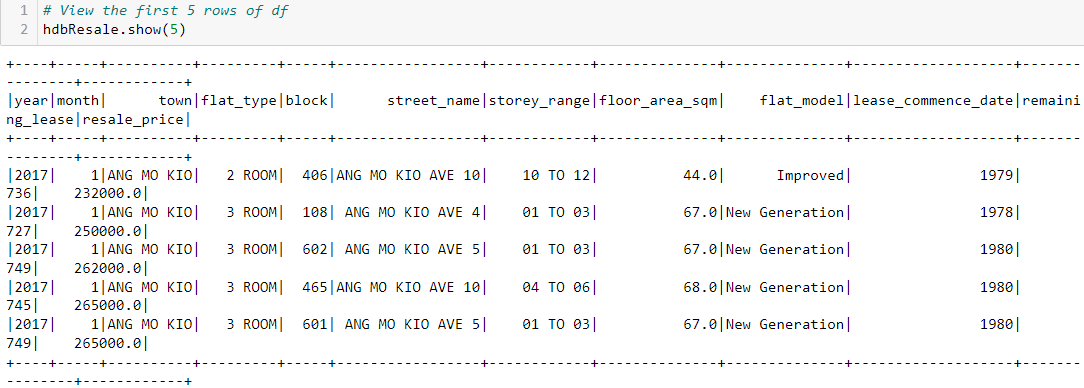
To display first 5 records of the dataset, .show(5) method is used (Figure 1)


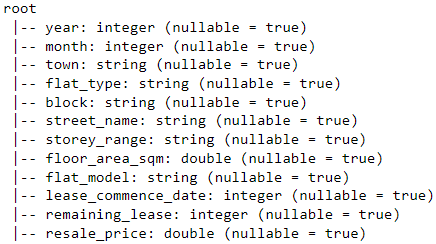 
To view the number of features and data type for each column, .printSchema() method is used. The dataset consists of various data types which are integer, string and double. 

### 1.3 Understand the Data <a id="part1.3"></a>
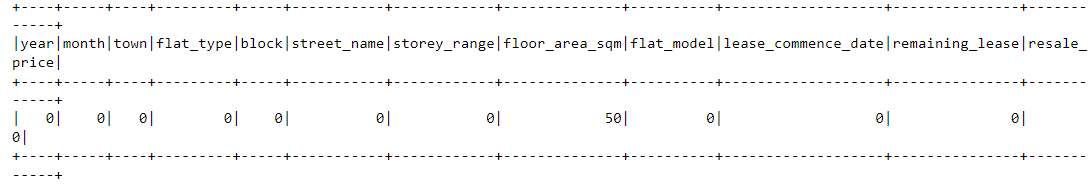
<a id="1.3"></a>
[Back to bottom (report)](#5.2)

The above result shows an overview count of null values of all dataframe columns. "floor_area_sqm" contains null values. (Figure 2)

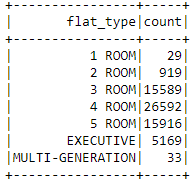

The above screenshot shows the number of transactions based on flat types. "4 ROOM" flat type is the most popular with the highest count. "1 ROOM" and "MULTI-GENERATION" have the least counts.

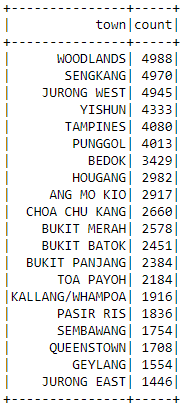

The above screenshot shows which town area has the highest count of transactions. Woodlands town has the highest count.

### 1.4 Formulate a Value Based Problem Statement <a id="part1.4"></a>

In Singapore, the selling price of HDB resale flats is largely influenced by various factors.

Using a linear regression model, this study aims to investigate on how the selling price of a HDB resale flat differs from one another, excluding $1 million dollar flats based on the following factors:
- flat_type
- flat_model
- floor_area_sqm
- storey_range
- town
- remaining_lease

This serves as a guide for sellers or interested buyers on the expected price of a HDB resale flat.

# 2. Exploratory Data Analysis and Data Cleansing <a id="part2"></a>
### 2.1 Interesting Trends <a id="part2.1"></a>
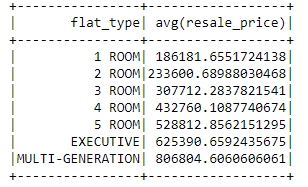

The bigger the size of flat type, the higher the average resale price.

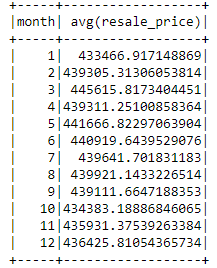

Monthly average resale price fluctuates. However, the variations are minimal.

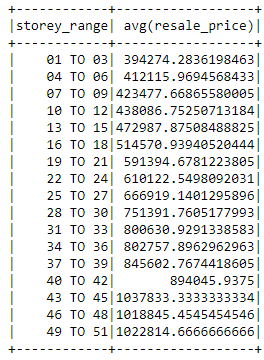

It shows a linear relationship between the storey range and the average resale price. As storey range increases, the average resale price also increases.

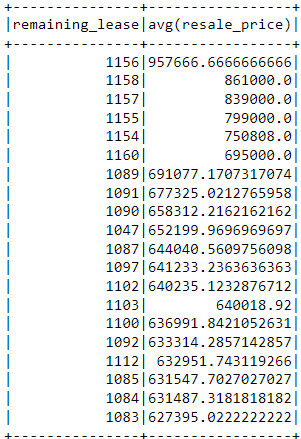

It shows that the longer the remaining_lease, the higher is the average resale price.

### 2.2 Anomalies <a id="part2.2"></a>
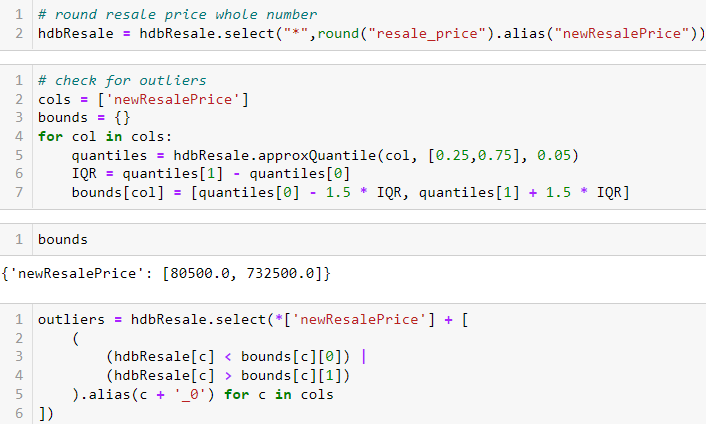
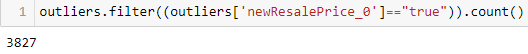

In this phase, outliers are present in target variable "newResalePrice". (Figure 3)

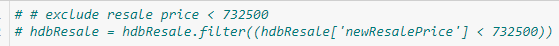

Filtering outliers based on the calculation "bounds" resale price are being carried out. However, this will not be adopted. (Figure 4)

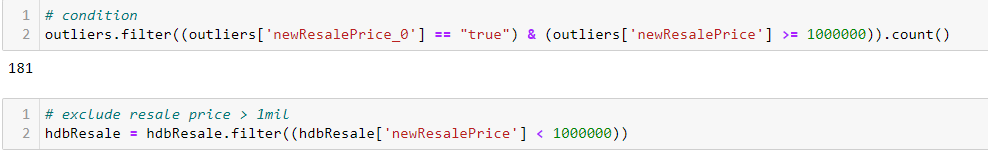

A filter is used to check the number of outliers that are present in "newResalePrice" with more than $1 million. Since the count is insignificant (181), therefore HDB resale prices that is more than > 1000000 will be excluded.

### 2.3 Conversion of Features <a id="part2.3"></a>
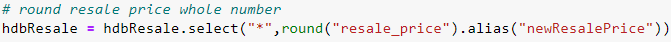

With reference to figure 1, "resale_price" is represented as double and HDB resale prices are usually represented as a whole number. Therefore, rounding off "resale_price" is necessary and the variable will also be renamed as "newResalePrice".

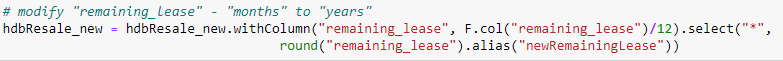

"remaining_lease" feature is modified from "months" to "years"

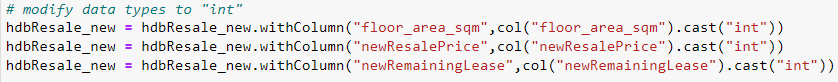.

These features are modified to "int" for better readability purpose.

### 2.4 Missing Value Treatment <a id="part2.4"></a>
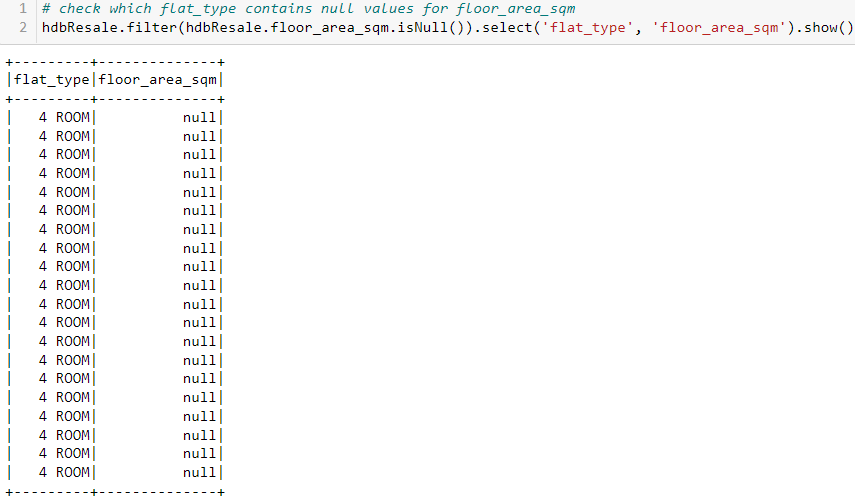

With reference to figure 2, filtering and selecting "floor_area_sqm" are used to identify which "flat_type" contains null values. Null values are present in "4 ROOM".

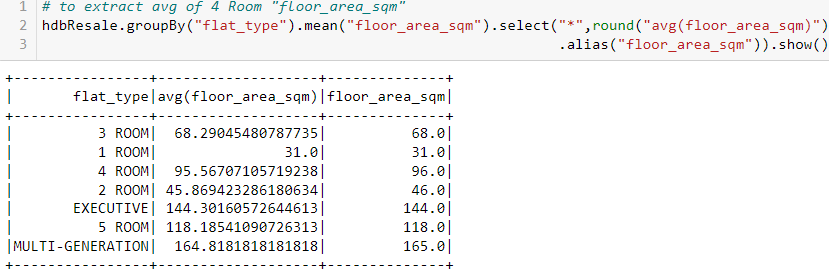

A groupBy function is used to find the average of "floor_area_sqm" based on "flat_type". The newly created column will be rounded off to the nearest whole number. 4 Room's average floor_area_sqm will be imputed in the subsequent code instead of dropping these nans entirely. 

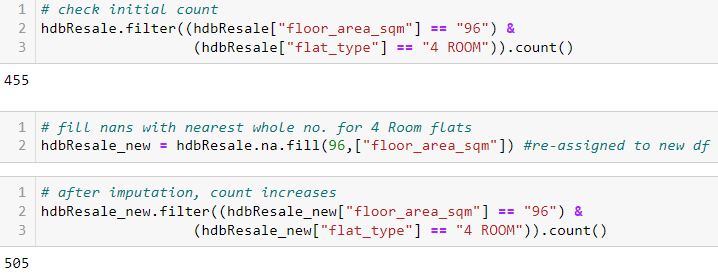

The above screenshot shows the initial and after imputation count where all the nans are modified to 96.

### 2.5 Adding and Dropping Features  <a id="part2.5"></a> 
 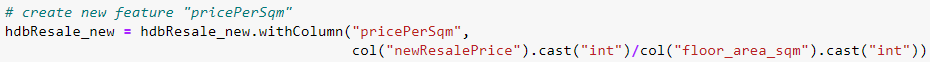

 A new feature "pricePerSqm" is created as this is useful for the prediction of HDB resale prices. Interested buyers or sellers will be interested to know the price per metre.

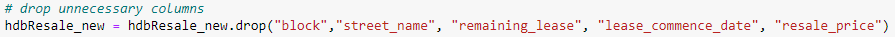

These columns will be dropped since they have least impact on the prediction of HDB resale and there are duplicates of features.
For example, "remaining_lease" and "resale_price" will have duplicates after rounding off to the nearest whole number which creates new features. 

# 3. Data Wrangling and Transformation <a id="part3"></a>
### 3.1 Categorical Data <a id="part3.1"></a>
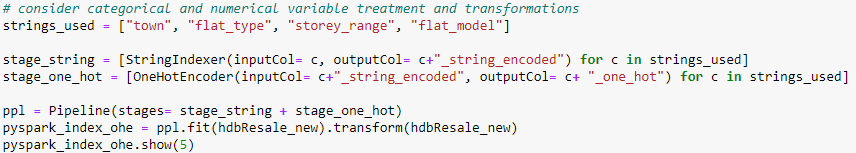
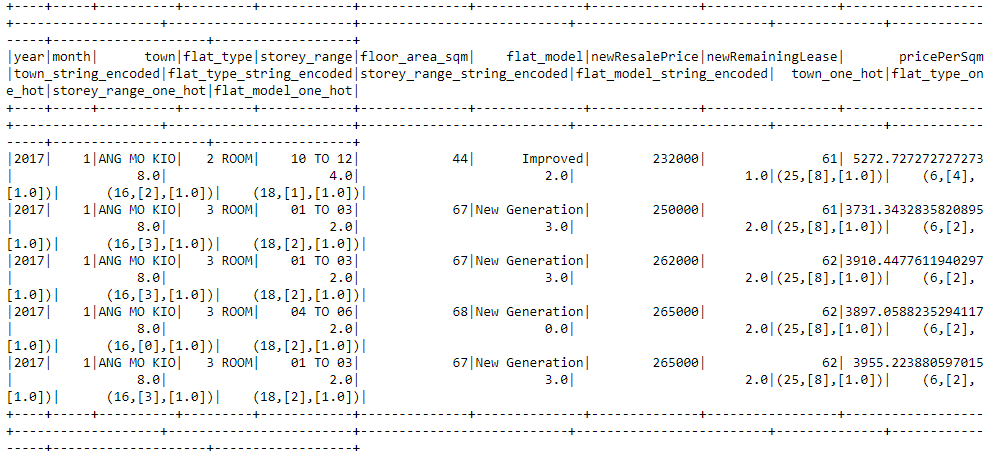


String indexer and one-hot encoder are used to encode the categorical features such as ""town", "flat_type", "storey_range" and "flat_model". Pipeline is used to transform these categorical features to numerical values. 
After encoding the categorical variables, the original features are dropped.

### 3.2 Scaling of Data <a id="part3.2"></a>

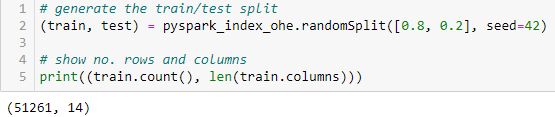

For my Train and Test Split, the ratios are 80% and 20% for training and testing data respectively. It also shows the number of rows and columns for my training data.

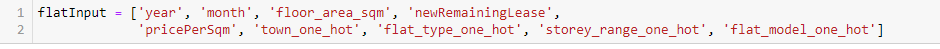

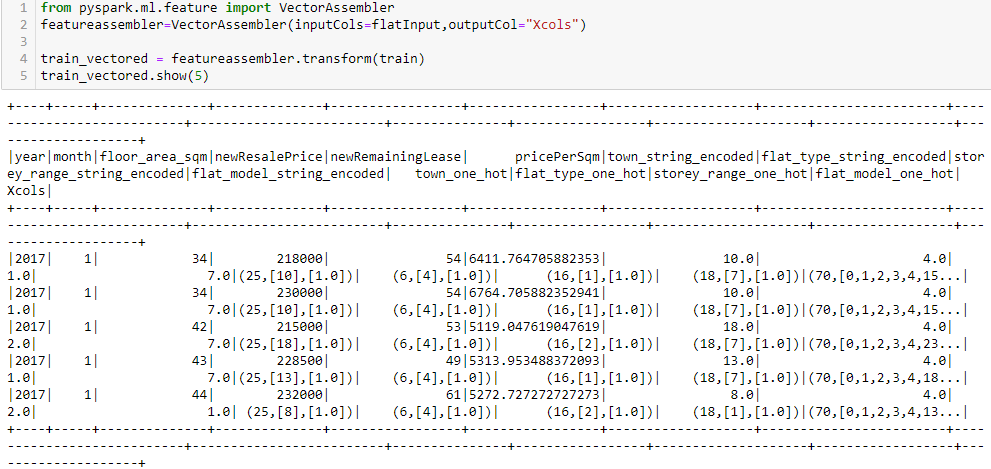
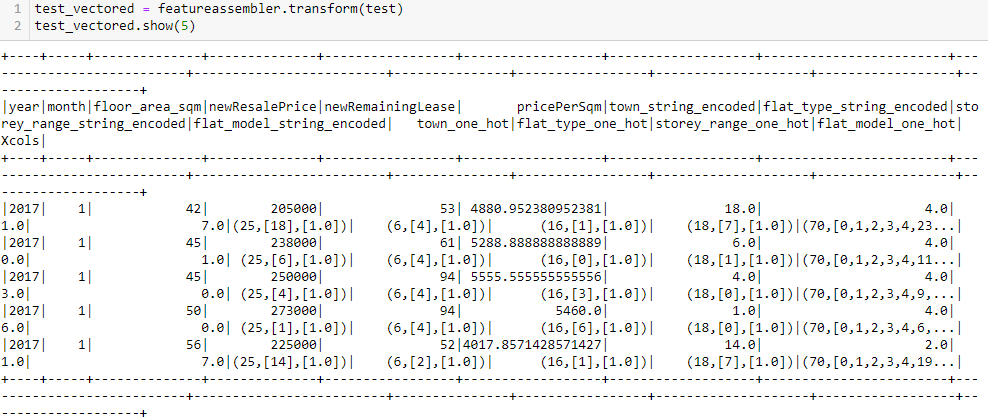

A list "flatInput" is created where suitable features are selected and used as inputCols in the VectorAssembler. This feature transformer helps to combine the given list of columns into a single vector column as "Xcols".
The above screenshot shows the transformed result train_vectored from the train and test data.

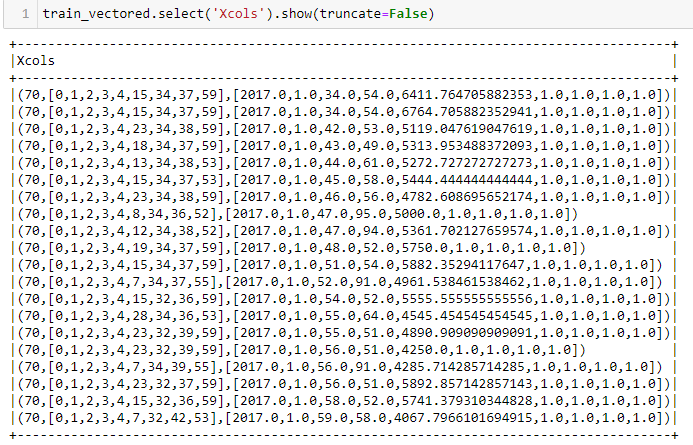

The above screenshot shows the full content of the columns without truncation. This method is useful for performing a sanity check to ensure the target variable "newResalePrice" is not present in  train_vectored "Xcols".

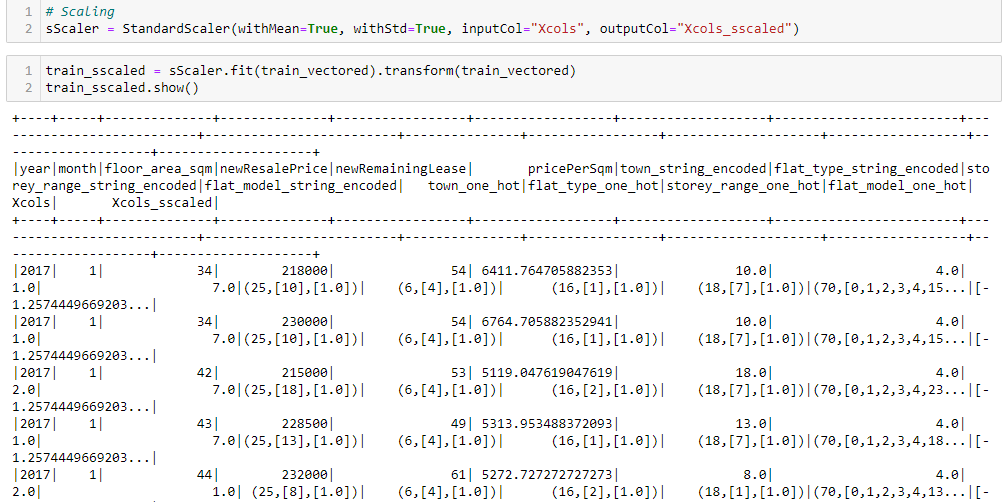

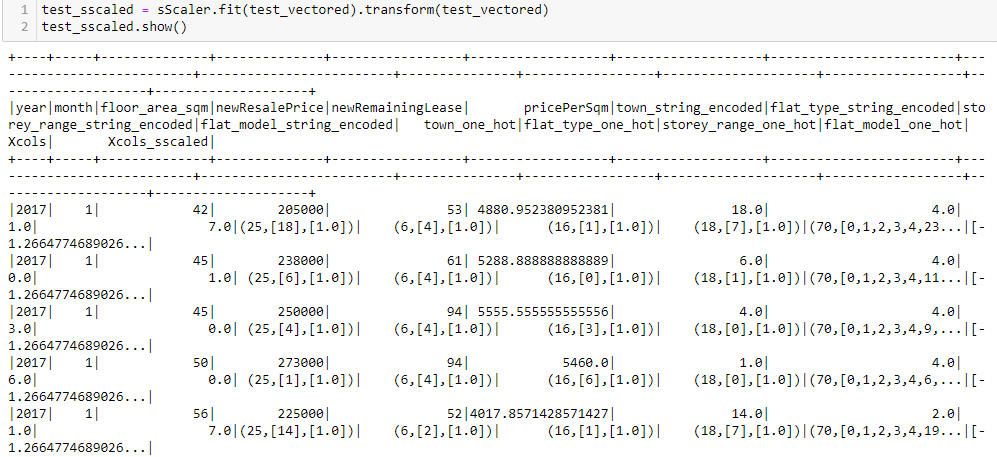

Standard scaler is used for both train and test data.

# 4. Machine Learning Modelling <a id="part4"></a>
### 4.1 Show Count of Rows and Columns <a id="part4.1"></a>


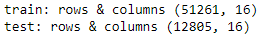
The above image shows the final count for both train and test respectively. Both train and test data have 16 columns but different count of rows. Training and testing data have 51261 and 12805 rows respectively.

### 4.2 Sample of 10 Rows before Modelling <a id="part4.2"></a>
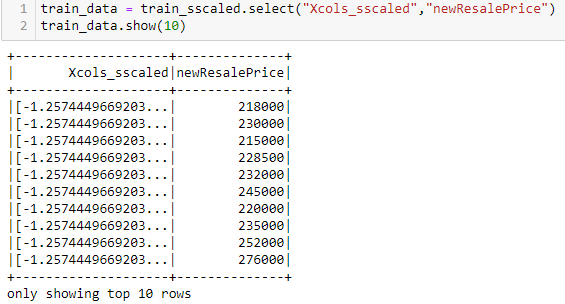
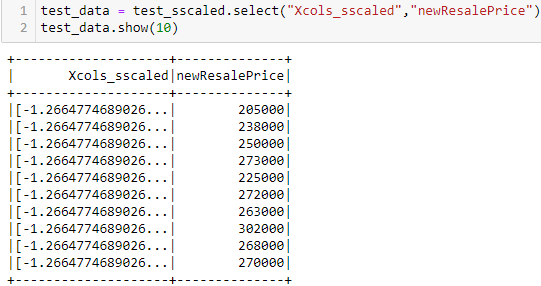

The above screenshot shows the first 10 records of "Xcols_sscaled" and "newResalePrice" in both train and test data. 

### 4.3 Build the Predictive Model <a id="part4.3"></a>

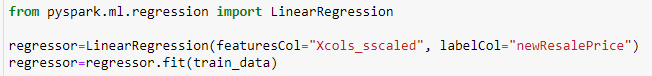

"Xcols_sscaled" and the target variable "newResalePrice" are placed in the regressor.

# 5. Model Evaluation and Selection <a id="part5"></a>
### 5.1 Utilize Model Metrics for Evaluation <a id="part5.1"></a>


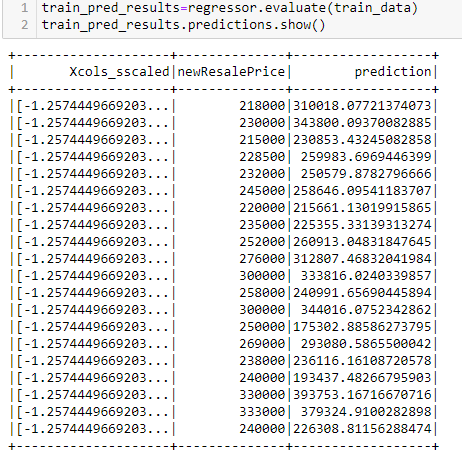

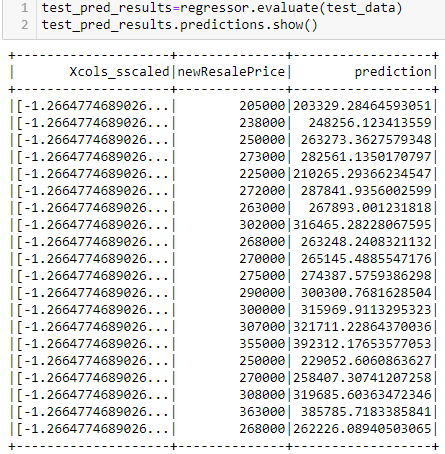

These results show the evaluation of predicted values as compared to its target variable "newResalePrice" for both train and test data.

### 5.2 Compare Models and Decide on Final Model <a id="part5.2"></a>

The subsequent cells show the evaluation (prediction) results as compared to its target variable "newResalePrice"
Several methods are conducted to fine tune the best result. 

These include choosing the type of encoder, either String Index or One Hot Encoder, to be placed in the VectorAssembler.


The screenshots of the following methods are as follows:
1) First screenshot shows the original model without any filtering of dataset

2) Second screenshot shows the model that excludes flat types which is 1 Room and Multi-Generation since these count transactions are very minimal as shown in 1.3 (Understanding the data) <a id="5.2"></a> [Back to code (report)](#1.3) 

3) Third screenshot shows model that excludes resale price of <732500. This figure is excluded and can be derived based on detecting outliers with reference to figure 3 "bounds" (upper quartile). This is to determine whether the removal of these outliers would improve the prediction of HDB resale prices. The machine learning model results does not seem desirable as most of the data will be removed. Therefore, this model is not chosen


4) Fourth screenshot shows model that excludes resale price of <732500 and flat types with 1 Room, as well as Multi-Generation

5) Last screenshot shows model that exclude resale price that is more than $1 million and one hot encoder for vector assembler

1) 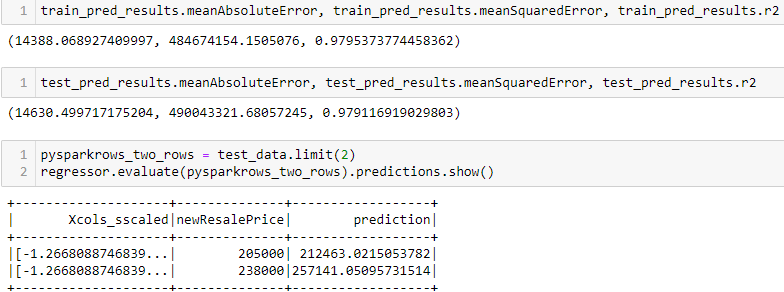

2) 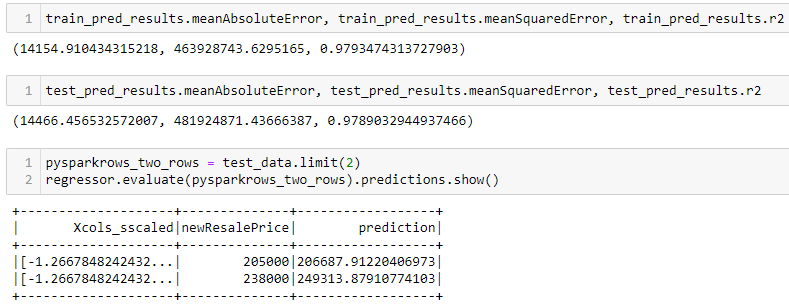

3) 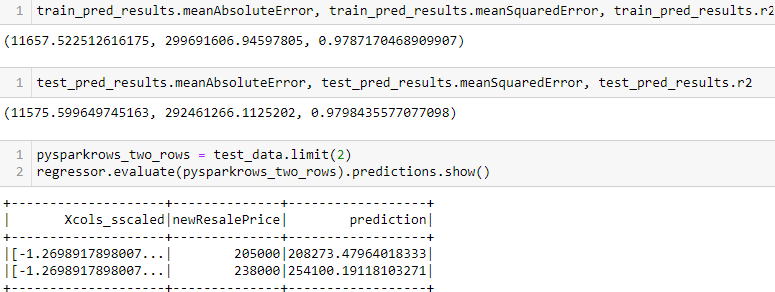

4) 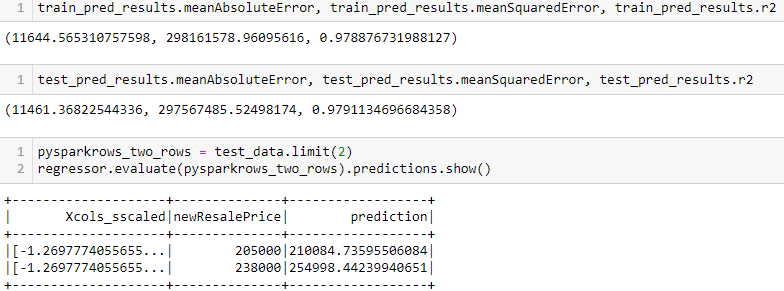

5) 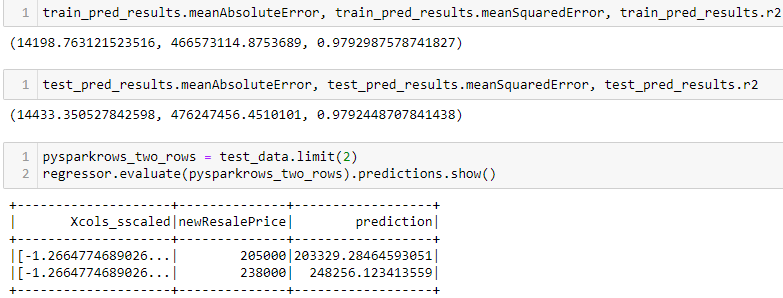

The last model is my preferred model as it has better performance.
The prediction is also much closer to its target and the difference between the r2 scores for both train and test are very minimal.

# 6. Summary and Further Improvements <a id="part6"></a>
### 6.1 Summarize your findings <a id="part6.1"></a>


       

- Exploration of dataset to find the count of transactions based on various "flat_type"
    - "1 Room" and "Multi-Generation" with the lowest count of transactions
    
    
- Removed unnecessary columns that would not be useful in the prediction of HDB resale prices such as "block","street_name", "lease_commence_date".  "remaining_lease" and "resale_price" are removed. This is due to the duplicate of these features ("remaining_lease" and "resale_price") by rounding off to the nearest whole number which creates new features. The new features are "newResalePrice" and "newRemainingLease"


- Detecting the count of outliers in 'newResalePrice'. 
    - Based on the outliers, using a filter to count the number of outliers that has "newResalePrice" >= 1000000
    - Filter df to < 1000000 due to low count of these transactions
    
    
- Modify "remaining_lease" from "months" to "years" and round to nearest whole number. New feature "newRemainingLease" is created


- Check for null count in df. Null values present in "floor_area_sqm".
    - Filter to select type of flat_type that has null values for "floor_area_sqm" ("4 Room")
    - Using groupBy method to extract the average floor area (rounded off to nearest whole number) based on 4 Room flat_type.
    - Fill these nans with the extracted value
    
    
- Added new feature, "pricePerSqm" to represent the price per floor_area_sqm.


- Encoding Categorical data
    - Using string indexer and one hot encoder for "town", "flat_type", "storey_range", "flat_model"
    - drop original features
    
    
- Train Test Split (80% train and 20% test data)
   
   
- Vector Assembler for train and test data 


- Standard scaling of dataset


- Show count of rows and columns of train and test data


- Build and evaluate Linear Regression Modelling


- "pricePerSqm" shows a high correlation with "newResalePrice"

### 6.2 Possible Further Improvements <a id="part6.2"></a>
[Back to top (code)](#top)

Possible further improvements that might help to improve the prediction model are as follows:

- Good to have features such as distance to the nearest MRT/LRT, distance from Central Business District (CBD), distance from nearest School. These are factors that could affect the resale price


- Using Geocoding approach by combining the block and street_name to derive the latitude and longitude so as to identify the specific location of the resale flat

### "Unlisted" Youtube Link to Video Presentation

In [56]:
# insert your link in this cell, you are allowed to comment it out
# youtube link: https://youtu.be/eXDCXiFA2PE